In [1]:
%matplotlib inline

from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.callbacks import TensorBoard
import numpy as np
import pickle
from datetime import datetime
from keras.callbacks import ModelCheckpoint
from keras import models
from matplotlib import pyplot as plt

(x_train, _), (x_test, _) = mnist.load_data()

In [2]:
RUN_ON_MNIST = True
L = 4

In [3]:
CHECKPOINTER = ModelCheckpoint(filepath='model_checkpoit.hdf5', 
                               monitor='val_loss',
                               verbose=1, 
                               save_best_only=True,
                               mode='auto')

# Notes:
* Add `Input` argument `channels_first` when using Z3 data and 
  change the input dimensions.
* You will have to manualy add periodic edges for periodic padding before real runn
* **requires** running the transform notebook to get the data into a format for the auto encoder

In [4]:
if RUN_ON_MNIST:
    input_obj = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_obj)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  

else:
    input_obj = Input(shape=(L*2, L*2, 1))
    x = Conv2D(16, (3, 3), strides=2, activation='relu', padding='same', use_bias=True)(input_obj)
    encoded = Conv2D(32, (3, 3), strides=2, activation='relu', padding='same', use_bias=True)(x)
    x = Conv2DTranspose(16, (3, 3), strides=2, activation='relu', padding='same', use_bias=True)(encoded)
    decoded = Conv2DTranspose(1, (3, 3), strides=2, activation='relu', padding='same', use_bias=True)(x)

autoencoder = Model(input_obj, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [5]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0     

In [6]:
if RUN_ON_MNIST:
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
    x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format
else:
    with open('pickle_data.pkl', 'rb') as f:
        all_data = pickle.load(f)
    all_data = all_data.astype('float32') / 5.0
    n_records = len(all_data)
    x_train = all_data[: n_records - int(n_records/4)]
    x_test = all_data[int(n_records/4) :]
    x_train = np.reshape(x_train, (len(x_train), L * 2, L * 2, 1))
    x_test = np.reshape(x_test, (len(x_test), L * 2, L * 2, 1))

In [7]:
x_train.shape

(60000, 28, 28, 1)

In [8]:
history = autoencoder.fit(
    x_train[: 20000], x_train[: 20000],
    epochs=20,
    batch_size=50,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[
        TensorBoard(log_dir='/tmp/autoencoder/{}'.format(datetime.now())),
        CHECKPOINTER
    ]
)

Epoch 1/20
399/400 [============================>.] - ETA: 0s - loss: 0.6913
Epoch 00001: val_loss improved from inf to 0.68981, saving model to model_checkpoit.hdf5
400/400 [==============================] - 10s 24ms/step - loss: 0.6913 - val_loss: 0.6898
Epoch 2/20
400/400 [==============================] - ETA: 0s - loss: 0.6880
Epoch 00002: val_loss improved from 0.68981 to 0.68597, saving model to model_checkpoit.hdf5
400/400 [==============================] - 10s 24ms/step - loss: 0.6880 - val_loss: 0.6860
Epoch 3/20
399/400 [============================>.] - ETA: 0s - loss: 0.6834
Epoch 00003: val_loss improved from 0.68597 to 0.68032, saving model to model_checkpoit.hdf5
400/400 [==============================] - 9s 24ms/step - loss: 0.6833 - val_loss: 0.6803
Epoch 4/20
398/400 [============================>.] - ETA: 0s - loss: 0.6761
Epoch 00004: val_loss improved from 0.68032 to 0.67093, saving model to model_checkpoit.hdf5
400/400 [==============================] - 10s 24ms/

In [9]:
for key in history.history:
    print(key)

loss
val_loss


In [10]:
autoencoder.load_weights('model_checkpoit.hdf5')

In [11]:
autoencoder.save('models/best_non_hparam_autoencoder.h5')

# Make a specific model for the activation tensors 

In [12]:
layers_to_encoded = int(len(autoencoder.layers)/2)

In [13]:
autoencoder.layers

In [14]:
layer_activations = [layer.output for layer in autoencoder.layers[:layers_to_encoded]]

In [15]:
activation_model = models.Model(
    inputs=autoencoder.input,
    outputs=layer_activations
)

In [16]:
x_test.shape

(10000, 28, 28, 1)

In [19]:
single_image = x_test[20]
activations = activation_model.predict(x_test[:50])

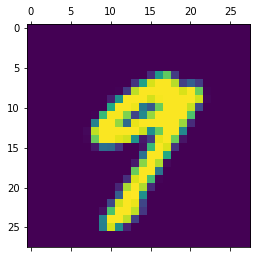

In [20]:
plt.matshow(single_image[:, :, 0])

In [21]:
len(activations)

7

In [22]:
first_layer_activation = activations[0]

In [23]:
first_layer_activation.shape

(50, 28, 28, 1)

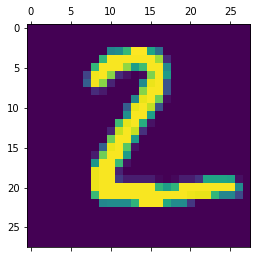

In [24]:
plt.matshow(first_layer_activation[1, :, :, 0], cmap='viridis')

Layer_activation shape (50, 28, 28, 16);    Layer name conv2d
Size 28;  N Features 16;  N Cols 1
Layer_activation shape (50, 14, 14, 16);    Layer name max_pooling2d
Size 14;  N Features 16;  N Cols 1
Layer_activation shape (50, 14, 14, 8);    Layer name conv2d_1
Size 14;  N Features 8;  N Cols 1
Layer_activation shape (50, 7, 7, 8);    Layer name max_pooling2d_1
Size 7;  N Features 8;  N Cols 1
Layer_activation shape (50, 7, 7, 8);    Layer name conv2d_2
Size 7;  N Features 8;  N Cols 1
Layer_activation shape (50, 4, 4, 8);    Layer name max_pooling2d_2
Size 4;  N Features 8;  N Cols 1


<ipython-input-27-70d53c1b9ac5>:25: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


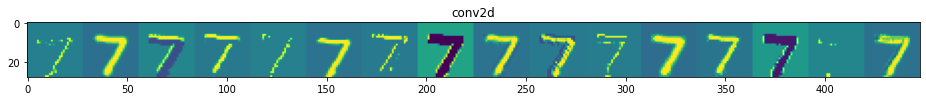

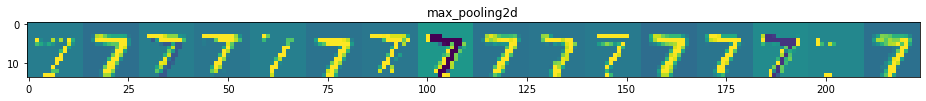

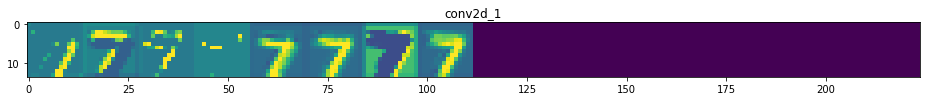

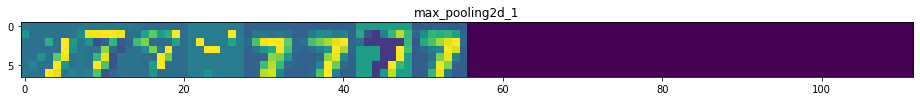

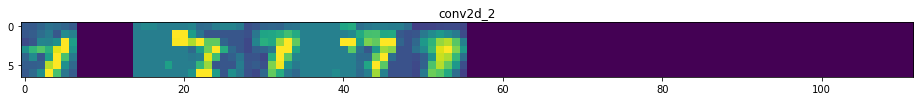

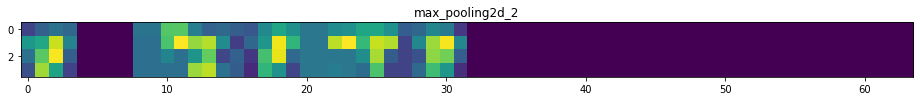

In [27]:
layer_names = []
for layer in autoencoder.layers[:layers_to_encoded]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

c = 0
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    if c == 0:
        c += 1
        continue
    print(f'Layer_activation shape {layer_activation.shape};    Layer name {layer_name}')
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = max([n_features // images_per_row, 1]) # Tiles the activation channels in this matrix
    print('Size {};  N Features {};  N Cols {}'.format(size, n_features, n_cols))
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            try:
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
            except IndexError:
                continue
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    c += 1